# Investigating New Movie Ratings

### Scenario

In lieu of the popular "Investigating Fandango Movie Ratings" project which uses data from 2015, we dive into a more recent exploration by:
- scraping together our own dataset of ratings (`movie_ratings_07-30-2023.csv`), and 
- investigating ratings for new movies released in theaters

from Metacritic, IMDb, Rotten Tomatoes, and Fandango. 

### Goal

We explore any trends and determine if Fandango (or perhaps a different movie critic) is inflating ratings.

### Result

We started off by scraping together a list of new movies released in theaters from each of the four movie critic sites. Sometime in 2019, Fandango stopped using the 5-star rating system. Instead, they now use a [verified Audience Score](https://editorial.rottentomatoes.com/article/introducing-verified-audience-score/) powered by Rotten Tomatoes. We pulled this score directly from Rotten Tomatoes.

To properly evaluate the ratings, we analyzed only movies that had all four critic ratings. It is evident that Fandango's ratings for new movie releases are still inflated (but in a different sense) when compared to the other critic sites. Unlike 2015 where they were rounding up ratings, the inflation today is due to the Audience Score they use which explicitly skews it towards favorable user ratings based on the definition: 

"The percentage of users we've confirmed bought tickets for this movie who rated it 3.5 stars or higher."

It is also shown that IMDb is slow to rate new releases compared to the other three critic sites. They have rated only 3% of the new movies when the other three have rated 97-100% of them. 

New movies released in theaters, on average, are rated with a score between 70-80 when rated by all four critics. When rated by at least two critics, the ratings are higher between 80-90. 

With the current batch of new releases, the top 5 movies are in the action/adventure and drama genres. The bottom 5 are comedy or horror movies. It remains true that Fandango rated both top 5 and bottom 5 movies higher than the other three critics.

Overall, for new releases, Fandango rates movies 11 points higher than the average and Metacritic rates them 10 points lower than the average. If one could only choose one site to peruse for reliable movie ratings, I suggest Rotten Tomatoes as their ratings on average resemble the average of all four critic sites combined. Also, because they include both their own Tomatometer rating and Verified Audience Score rating for movies, the one-stop shop to compare official and user ratings makes Rotten Tomatoes the better choice.

# Table of Contents

1. Import the libraries
2. Scrape the data
   - Instantiate HTTP headers to request data
   - Metacritic: New Releases in Theaters
   - IMDb: Feature Film (Sorted by Popularity Ascending)
   - Rotten Tomatoes: New Movies in Theaters
   - Fandango: From Rotten Tomatoes' Verified Audience Score
3. Merge or import the data
4. Clean the data
   - Functions and definitions
   - NaN values
5. Explore the data
   - Movies with no null ratings
   - Movie ratings by number of critics
   - Movie ratings by month
   - Top 5 newly released movie ratings
   - Bottom 5 newly released movie ratings
   - Average ratings by movie critic

## Import the libraries

In [1]:
import requests
import logging
import csv
import re
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
import ipywidgets as widgets
from datetime import datetime
from bs4 import BeautifulSoup

# Set to CRITICAL (remove +1) and Restart/Run All to show logging details
logging.basicConfig(level=logging.CRITICAL+1)

# Suppress low-level warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Set chart defaults
sns.set_theme(style="whitegrid")
sns.set_palette("muted")
plt.rcParams['font.family'] = 'arial'

## Scrape the data

To build our own dataset, we turn to BeautifulSoup to web scrape ratings from:
1. Metacritic
2. IMDb
3. Rotten Tomatoes

Fandango uses the verified Audience Score from Rotten Tomatoes so we'll pull those ratings from there.

### Instantiate HTTP headers to request data

In [2]:
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36",
    "Accept-Language": "en-US,en;q=0.9"
}

### Metacritic: New Releases in Theaters

In [3]:
# Pull from all three pages
metacritic_url1 = "https://www.metacritic.com/browse/movies/release-date/theaters/date"
metacritic_url2 = "https://www.metacritic.com/browse/movies/release-date/theaters/date?page=1"
metacritic_url3 = "https://www.metacritic.com/browse/movies/release-date/theaters/date?page=2"

metacritic = {}

for url in [metacritic_url1, metacritic_url2, metacritic_url3]:
    response = requests.get(url, headers=headers)
    website_html = response.text

    soup = BeautifulSoup(website_html, "html.parser")

    movie_links = soup.find_all("td", class_="clamp-summary-wrap")
    
    for link in movie_links:
        try:
            metacritic[link.find("h3").get_text().strip().lower().replace("–","-").replace(",","").replace("ii","2")] = float(link.find('div', class_=re.compile(r"metascore_w large movie.*")).get_text())
        except ValueError:
            metacritic[link.find("h3").get_text().strip().lower().replace("–","-").replace(",","").replace("ii","2")] = float(np.nan)
                    
logging.critical(metacritic)
print(len(metacritic))


229


### IMDb: Feature Film (Sorted by Popularity Ascending)

In [4]:
imdb_urls = [
    "https://www.imdb.com/search/title/?title_type=feature",
    "https://www.imdb.com/search/title/?title_type=feature&start=51&ref_=adv_nxt",
    "https://www.imdb.com/search/title/?title_type=feature&start=101&ref_=adv_nxt",
    "https://www.imdb.com/search/title/?title_type=feature&start=151&ref_=adv_nxt",
    "https://www.imdb.com/search/title/?title_type=feature&start=201&ref_=adv_nxt",
    "https://www.imdb.com/search/title/?title_type=feature&start=251&ref_=adv_nxt",
    "https://www.imdb.com/search/title/?title_type=feature&start=301&ref_=adv_nxt",
    "https://www.imdb.com/search/title/?title_type=feature&start=351&ref_=adv_nxt",
    "https://www.imdb.com/search/title/?title_type=feature&start=401&ref_=adv_nxt",
    "https://www.imdb.com/search/title/?title_type=feature&start=451&ref_=adv_nxt",
    ]

imdb = {}

for url in imdb_urls:

    response = requests.get(url, headers=headers)
    website_html = response.text

    soup = BeautifulSoup(website_html, "html.parser")
    
    movie_items = soup.find_all("h3", class_="lister-item-header")
    movie_rating_texts = soup.find_all("div", attrs={"name":"ir"})
    
    # Multiply IMDb rating by 10 to convert to 100 pt scale similar to the other websites
    for item, rating in zip(movie_items, movie_rating_texts):
        imdb[item.a.text.strip().lower().replace("–","-").replace(",","").replace("ii","2")] = float(rating.strong.text)*10

logging.critical(imdb)
print(len(imdb))

459


### Rotten Tomatoes: New Movies in Theaters

In [5]:
rottentomatoes_url = "https://www.rottentomatoes.com/browse/movies_in_theaters/sort:popular?page=5"

rottentomatoes = {}

response = requests.get(rottentomatoes_url, headers=headers)
website_html = response.text

soup = BeautifulSoup(website_html, "html.parser")

movie_title_texts = soup.find_all("span", attrs={"data-qa":"discovery-media-list-item-title"})

movie_rating_texts = soup.find_all("score-pairs", attrs={"criticsscore": True})
for item, rating in zip(movie_title_texts, movie_rating_texts):
    if rating["criticsscore"]=="":
        rating["criticsscore"] = np.nan
    else:
        rating["criticsscore"] = int(rating["criticsscore"])
    rottentomatoes[item.text.strip().lower().replace("–","-").replace(",","").replace("ii","2")] = rating["criticsscore"]
    
dates = {}
date_format = "%b %d, %Y"
movie_open_dates = soup.find_all("span", attrs={"data-qa":"discovery-media-list-item-start-date"})
for item, date in zip(movie_title_texts, movie_open_dates):
    if date.text.strip().startswith("Opened"):
        date_string = date.text.strip()[len("Opened "):]
    date_datetime = datetime.strptime(date_string, date_format)
    date_formatted = date_datetime.strftime("%Y-%m-%d")
    dates[item.text.strip().lower().replace("–","-").replace(",","").replace("ii","2")] = date_formatted
    
logging.critical(rottentomatoes)
logging.critical(dates)
print(len(rottentomatoes))

101


### Fandango: From Rotten Tomatoes' Verified Audience Score

In [6]:
fandango = {}

movie_rating_texts = soup.find_all("score-pairs", attrs={"audiencescore": True})
for item, rating in zip(movie_title_texts, movie_rating_texts):
    if rating["audiencescore"]=="":
        rating["audiencescore"] = np.nan
    else:
        rating["audiencescore"] = int(rating["audiencescore"])
    fandango[item.text.strip().lower().replace("–","-").replace(",","").replace("ii","2")] = rating["audiencescore"]
    
logging.critical(fandango)
print(len(fandango))

101


## Merge or import the data

In [7]:
all_movies = set(list(metacritic.keys()) + list(imdb.keys()) + list(rottentomatoes.keys()) + list(fandango.keys()))
all_movie_ratings = {}
for movie in all_movies:
    all_movie_ratings[movie] = [metacritic.get(movie, np.nan), imdb.get(movie, np.nan), rottentomatoes.get(movie, np.nan), fandango.get(movie, np.nan)]

# Comment the following line out and uncomment the last line to follow the results in this project.
filename = "movie_ratings.csv"

# Write data to .csv file (one column per movie site)
default_release_date = np.nan
with open(filename, mode='w', newline='', encoding="utf-8-sig") as file:
    writer = csv.writer(file)
    writer.writerow(["Movie", "Release Date", "Metacritic", "IMDb", "Rotten Tomatoes", "Fandango"])
    for movie, rankings in all_movie_ratings.items():
        # Use pop() method with default value to get the release date for each movie
        release_date = dates.pop(movie, default_release_date)
        writer.writerow([movie, release_date] + rankings)

# In the case of a runtime error, one or more of the movie critic sites restructured their page(s).
# Either 
#   (1) Hard mode: Update the pertaining web scraping code, or
#   (2) Easy mode: Uncomment and use the following data snapshotted on July 30 instead:
# filename = "movie_ratings_07-30-2023.csv"

## Clean the data

### Functions and Definitions

We read the scraped data in to a dataframe:

In [8]:
df = pd.read_csv(filename, encoding="UTF-8-sig")

To simplify many of the code blocks used in this project, we instantiate the list of movie critic sitees into a variable called `critics`:

In [9]:
critics = ["Metacritic", "IMDb", "Rotten Tomatoes", "Fandango"]

We define the following parameters to override the default settings when constructing charts:

In [10]:
def chart_theme():
    sns.despine(top=True, bottom=True, left=True, right=True)
    plt.grid(axis="y", alpha=0.3)
    plt.xlabel("")
    plt.ylabel("")
    plt.tick_params(axis="both", length=0)
    plt.tight_layout()

### NaN values

We first check the number of NaNs for each movie critic.

In [11]:
for i in range(5):
    count_four_nan = df[df.isnull().sum(axis=1) == i].shape[0]
    print(f"Number of movies with {i} NaN values:", count_four_nan)

print(f"Total number of new movies: {len(df)}")

Number of movies with 0 NaN values: 26
Number of movies with 1 NaN values: 28
Number of movies with 2 NaN values: 16
Number of movies with 3 NaN values: 19
Number of movies with 4 NaN values: 501
Total number of new movies: 679


Having 4 NaN values essentially means no ratings were provided for that particular movie so we remove those rows:

In [12]:
df.dropna(subset=critics, how="all", inplace=True)
print(f"Total number of new movies: {len(df)}")

Total number of new movies: 571


We add a column to count the number of NaN values in each row:

In [13]:
df["nan_count"] = df[critics].isnull().sum(axis=1)

Since we pulled in a large number of IMDb movies to try and capture as many new releases as possible, we remove all movies that have only an IMDb rating. To avoid one-offs, we do the same for the other three critics by removing all rows that have only one rating (three NaN values):

In [14]:
df = df[df["nan_count"] < 3]
print(f"Total number of new movies: {len(df)}")

Total number of new movies: 78


This is now a manageable list of movies with two or more critic ratings. We add another column to calculate the average ratings among the movie critic sites:

In [15]:
df['Average Score'] = df[critics].mean(axis=1)

A sample of the cleaned dataset is shown below:

In [16]:
df.head()

,Movie,Release Date,Metacritic,IMDb,Rotten Tomatoes,Fandango,nan_count,Average Score
4,north circular,2023-07-28,75.0,NaN,100.0,NaN,2,87.500000
12,it ain't over,2023-05-12,79.0,NaN,98.0,96.0,1,91.000000
18,scarlet,2023-06-09,74.0,NaN,78.0,98.0,1,83.333333
22,theater camp,2023-07-14,68.0,70.0,83.0,77.0,0,74.500000
30,susie searches,2023-07-28,45.0,NaN,48.0,NaN,2,46.500000


## Explore the data

### Movies with no null ratings

It will give us a better sense of the average ratings if we analyze movie releases that have ratings from all four movie critic sites. 

In [17]:
all_ratings = df[df["nan_count"]==0].copy().reset_index(drop=True)
all_ratings.sort_values(by="Average Score", ascending=False)

,Movie,Release Date,Metacritic,IMDb,Rotten Tomatoes,Fandango,nan_count,Average Score
20,past lives,2023-06-30,94.0,84.0,98.0,94.0,0,92.50
1,oppenheimer,2023-07-21,88.0,87.0,94.0,92.0,0,90.25
22,mission: impossible - dead reckoning part one,2023-07-12,81.0,80.0,96.0,94.0,0,87.75
15,spider-man: across the spider-verse,2023-06-02,86.0,63.0,96.0,94.0,0,84.75
23,barbie,2023-07-21,80.0,75.0,89.0,86.0,0,82.50
9,guardians of the galaxy vol. 3,2023-05-05,64.0,81.0,82.0,94.0,0,80.25
16,the blackening,2023-06-16,69.0,77.0,87.0,85.0,0,79.50
13,joy ride,2023-07-07,75.0,61.0,91.0,81.0,0,77.00
24,elemental,2023-06-16,58.0,76.0,73.0,93.0,0,75.00
0,theater camp,2023-07-14,68.0,70.0,83.0,77.0,0,74.50


The average ratings for movies rated by all four critics are no higher than 92.5 and no lower than 54.75.

### Movie ratings by number of critics

In [18]:
def boxplot(num_critics):
    new_df = df[df["nan_count"]==len(critics)-num_critics].copy()
    variable_df = new_df.drop(columns=['Release Date','nan_count', 'Average Score'])
    melted_df = variable_df.melt(id_vars='Movie', var_name='Critic', value_name='Rating')
    plt.figure(figsize=(6, 3))
    sns.boxplot(x='Critic', 
                y='Rating', 
                data=melted_df, 
                palette='muted')
    plt.suptitle("Ratings by Critic for New Movie Releases", fontsize=20, y=0.9)
    plt.ylim(20,100)
    spell_out_numbers = {1: "One", 2: "Two", 3: "Three", 4: "Four"}
    if num_critics==1:
        plt.title(f"{len(new_df)} Movies Rated by One Critic")
    else:
        plt.title(f"{len(new_df)} Movies Rated by {spell_out_numbers[num_critics]} Critics")    
    chart_theme()
    plt.ylim(20,100)
    plt.show()
    
    print(f"Number of critics: {num_critics}")
    for critic in critics:
        print(f"{critic}: {round(new_df[critic].notnull().sum()/len(new_df)*100)}%")

In [19]:
# If the boxplot produces an error or doesn't update when using the slider, cut, run, repaste, and rerun this code cell.
critics = ["Metacritic", "IMDb", "Rotten Tomatoes", "Fandango"]
num_critics_slider = widgets.IntSlider(
                                    value=4, min=2, max=4, 
                                    description="Number of Critics (2-4)", 
                                    style={"description_width":"initial"},
                                    continuous_update=True,
                                    layout=widgets.Layout(width="35%")
                                    )

widgets.interactive(boxplot, num_critics=num_critics_slider)

interactive(children=(IntSlider(value=4, description='Number of Critics (2-4)', layout=Layout(width='35%'), ma…

>Included images below if the widget above fails to load.

<img src="demos/critics_two.png" alt="showing ratings by critic for two critics">

<img src="demos/critics_three.png" alt="showing ratings by critic for three critics">

<img src="demos/critics_four.png" alt="showing ratings by critic for four critics">

Fandango and Rotten Tomatoes rate new releases higher than Metacritic and IMDb. Recall Fandango uses Rotten Tomatoes' verified Audience Score powered by actual movie watchers. This makes sense as users are more likely to rate movies more quickly than movie critics. It may be that early raters score based solely on whether they liked the film or not which may be why the ratings are higher. Late raters may be influenced by opinions that may have formed prior to watching the movie, making a more informed decision. 

We also see that IMDb is slow to provide official movie ratings. For movies that were rated by three critics, only 7% of them were rated by IMDb whereas they were rated by Metacritic, Rotten Tomatoes, and Fandango 93%, 100%, and 100% of the time. 

We explore average ratings of new releases by month and average age of movies on each site to see if we can discern any trends.

### Movie ratings by month

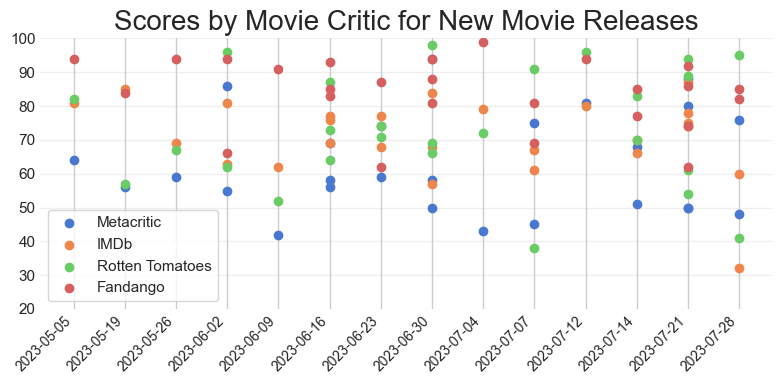

In [20]:
all_ratings.sort_values(by='Release Date', inplace=True)

plt.figure(figsize=(8, 4))
for critic in critics:
    plt.scatter(all_ratings['Release Date'], all_ratings[critic], label=critic)
plt.title("Scores by Movie Critic for New Movie Releases", fontsize=20)
plt.xlabel("Release Date", fontsize=12)
plt.ylabel("Scores", fontsize=12)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.legend()
chart_theme()
plt.ylim(20,100)
plt.show()

For movies with ratings from all four movie critic sites, there doesn't seem to be a discernable trend in ratings over time. What is clear however is the highest ratings typically come from Fandango or Rotten Tomatoes and the lowest ratings come from Metacritic or Rotten Tomatoes.

### Top 5 newly released movie ratings

In [21]:
top_five = all_ratings.sort_values(by="Average Score", ascending=False).head()
top_five

,Movie,Release Date,Metacritic,IMDb,Rotten Tomatoes,Fandango,nan_count,Average Score
20,past lives,2023-06-30,94.0,84.0,98.0,94.0,0,92.50
1,oppenheimer,2023-07-21,88.0,87.0,94.0,92.0,0,90.25
22,mission: impossible - dead reckoning part one,2023-07-12,81.0,80.0,96.0,94.0,0,87.75
15,spider-man: across the spider-verse,2023-06-02,86.0,63.0,96.0,94.0,0,84.75
23,barbie,2023-07-21,80.0,75.0,89.0,86.0,0,82.50


Listed above are the top 5 movies in descending order by average score. 

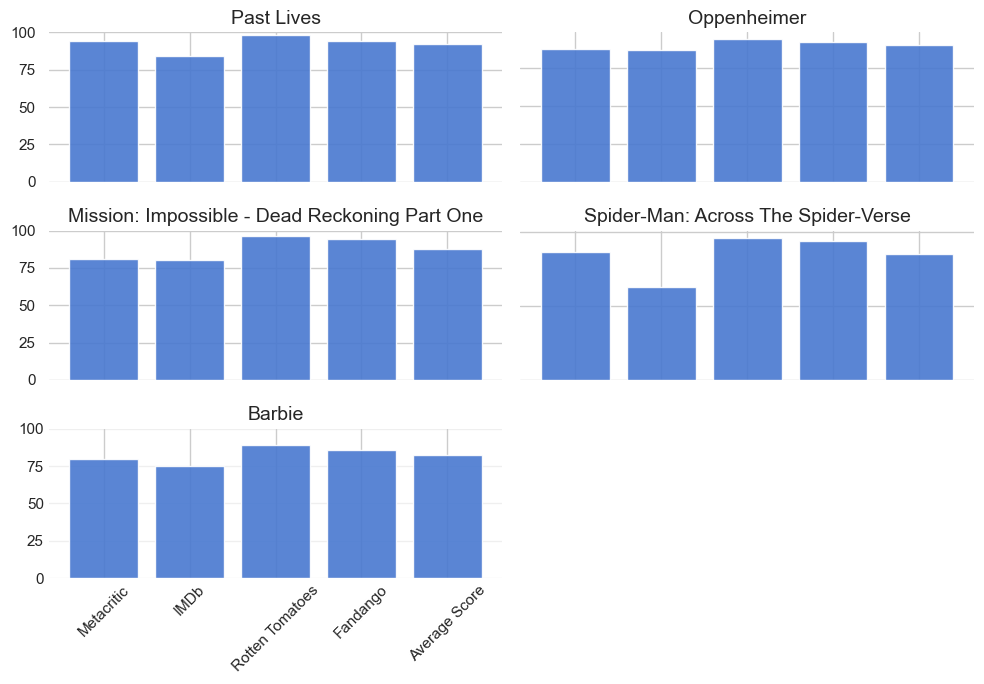

In [22]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 7), sharex=True)

for i, (index, row) in enumerate(top_five.iterrows()):
    row_idx = i // 2
    col_idx = i % 2
    movie_name = row['Movie']
    ratings = row[['Metacritic', 'IMDb', 'Rotten Tomatoes', 'Fandango', 'Average Score']]
    scores = ratings.index.tolist()
    
    axes[row_idx, col_idx].bar(scores, ratings, alpha=0.9)
    axes[row_idx, col_idx].set_title(f"{movie_name.title()}", fontsize=14)
    if col_idx == 0:
        axes[row_idx, col_idx].set_ylim(0,100)
    else:
        axes[row_idx, col_idx].set_yticklabels([])

for i in range(len(top_five), 3*2):
    row_idx = i // 2
    col_idx = i % 2
    fig.delaxes(axes[row_idx, col_idx])
    
plt.xticks(rotation=45)
chart_theme()
plt.show()

Two of the top 5 are action/adventure movies: 
1. Mission: Impossible - Dead Reckoning Part One, and 
2. Spider-Man: Across the Spider-Verse. 

Three are partially drama movies:
1. Past Lives (Romance/Drama)
2. Oppenheimer (Drama/Thriller)
3. Barbie (Comedy/Drama)

It appears that the most popular new releases for late Spring to early Summer 2023 are action/adventure or drama movies.

For the top 5 newly released movies, Rotten Tomatoes and Fandango consistently had the highest rankings while IMDb had the lowest rankings. At a glance, Metacritic seems to resemble the average of all four critic sites.

We see if this holds true for the lowest ranked movies.

### Bottom 5 newly released movie ratings

In [23]:
bottom_five = all_ratings.sort_values(by="Average Score", ascending=True).head()
bottom_five

,Movie,Release Date,Metacritic,IMDb,Rotten Tomatoes,Fandango,nan_count,Average Score
11,insidious: the red door,2023-07-07,45.0,67.0,38.0,69.0,0,54.75
2,haunted mansion,2023-07-28,48.0,60.0,41.0,85.0,0,58.50
21,the beanie bubble,2023-07-21,50.0,78.0,54.0,62.0,0,61.00
14,transformers: rise of the beasts,2023-06-09,42.0,62.0,52.0,91.0,0,61.75
25,ruby gillman teenage kraken,2023-06-30,50.0,57.0,66.0,81.0,0,63.50


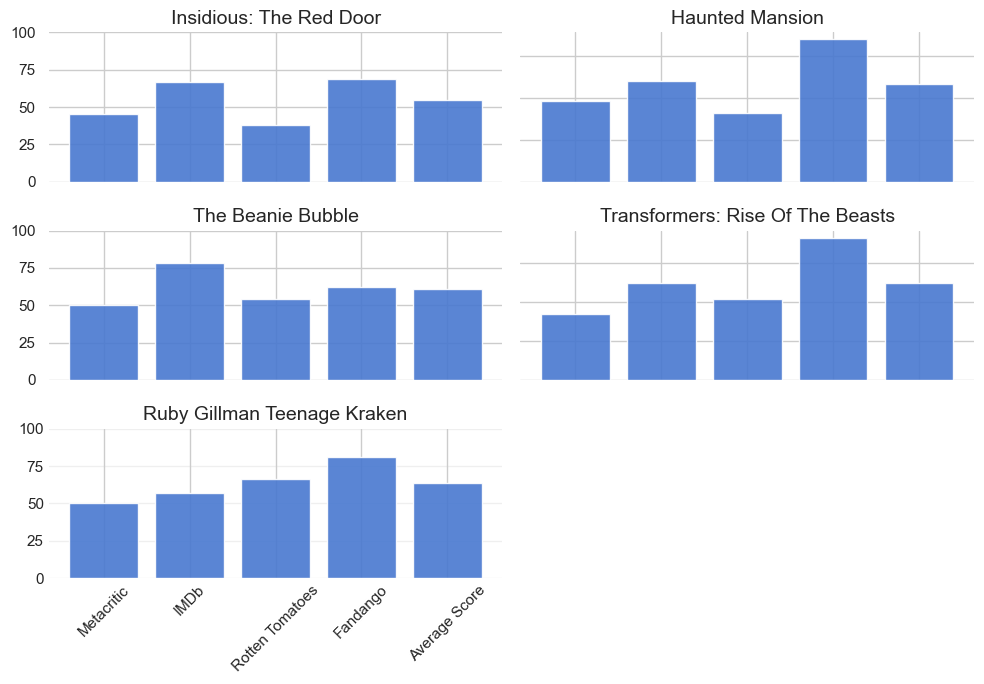

In [24]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 7), sharex=True)

for i, (index, row) in enumerate(bottom_five.iterrows()):
    row_idx = i // 2
    col_idx = i % 2
    movie_name = row['Movie']
    ratings = row[['Metacritic', 'IMDb', 'Rotten Tomatoes', 'Fandango', 'Average Score']]
    scores = ratings.index.tolist()
    
    axes[row_idx, col_idx].bar(scores, ratings, alpha=0.9)
    axes[row_idx, col_idx].set_title(f"{movie_name.title()}", fontsize=14)
    if col_idx == 0:
        axes[row_idx, col_idx].set_ylim(0,100)
    else:
        axes[row_idx, col_idx].set_yticklabels([])

for i in range(len(bottom_five), 3*2):
    row_idx = i // 2
    col_idx = i % 2
    fig.delaxes(axes[row_idx, col_idx])
    
plt.xticks(rotation=45)
chart_theme()
plt.show()

Fandango continues to rate movies highly, even for those in the bottom 5 with the exception of The Beanie Bubble. 

Insidious: The Red Door (Horror/Mystery)
Haunted Mansion (Fantasy/Comedy)
The Beanie Bubble (Comedy)
Transformers: Rise of the Beasts (Action/Sci-fi)
Ruby Gillman, Teenage Kraken (Action/Comedy)

Interesting, three of the bottom 5 movies are comedies. It is also worth noting that while Haunted Mansion is labeled a fantasy/comedy, the title may lead those who don't know anything about the film to believe it is a horror movie. 

In short, it appears that comedy and horror movies are the least popular for this batch of new releases in theaters.


### Average ratings by movie critic

Fandango           84.0
Rotten Tomatoes    73.0
Average Score      73.0
IMDb               71.0
Metacritic         63.0
dtype: float64


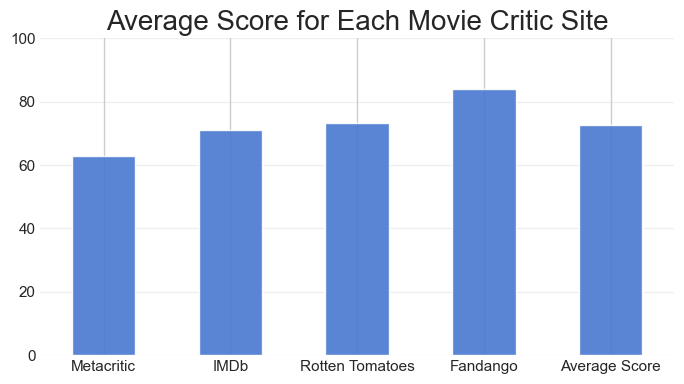

In [25]:
average_scores = all_ratings[['Metacritic', 'IMDb', 'Rotten Tomatoes', 'Fandango', 'Average Score']].mean()
print(round(average_scores.sort_values(ascending=False)))

plt.figure(figsize=(7, 4))
average_scores.plot(kind='bar', alpha=0.9)

plt.title("Average Score for Each Movie Critic Site", fontsize=20)
plt.xticks(rotation=0)
plt.ylim(0, 100) 
chart_theme()
plt.show()

It is clear that Fandango has higher than average movie ratings for new releases. While their score is based on user ratings, we see that they have the following disclaimer for the verified Audience Score they use.

<img src="demos/fandango_barbie.png" alt="verified audience score info">

The above contains recent ratings for the new Barbie movie, some tagged as Verified and others not. The Audience Score implies that unverified ratings are not included. To be able to provide a Verified rating, the user not only needs to have a Rotten Tomatoes account but also verify they bought a ticket for that movie:

<img src="demos/rotten_tomatoes_audience_score.png" alt="audience score definition">

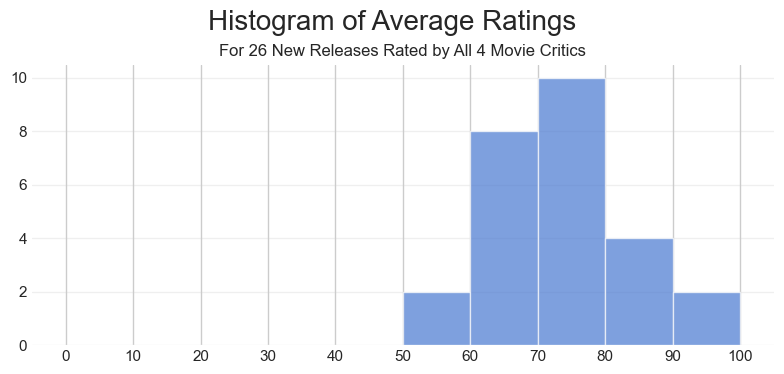

In [26]:
plt.figure(figsize=(8, 4))
bins = range(0, 101, 10)
plt.hist(all_ratings['Average Score'], bins=bins, alpha=0.7)
plt.suptitle("Histogram of Average Ratings", fontsize=20, y=.93)
plt.title(f"For {len(all_ratings)} New Releases Rated by All 4 Movie Critics")
plt.xticks(bins)
chart_theme()
plt.show()

It is clear across all movie critic sites that the majority of new releases rated by all four movie critics are rated more highly than poorly, most of them between a rating of 70-80.

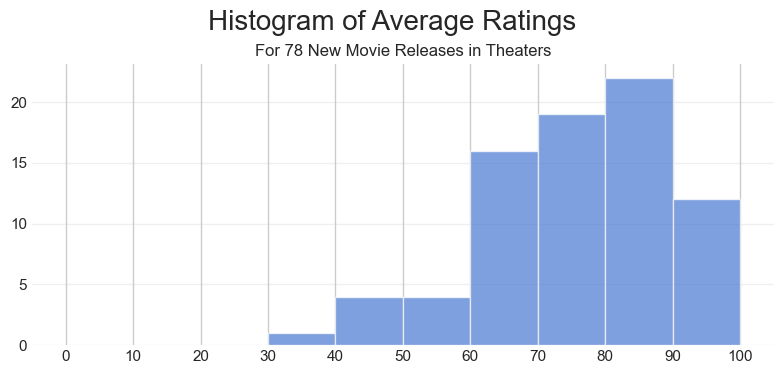

In [27]:
plt.figure(figsize=(8, 4))
bins = range(0, 101, 10)
plt.hist(df['Average Score'], bins=bins, alpha=0.7)
plt.suptitle("Histogram of Average Ratings", fontsize=20, y=.93)
plt.title(f"For {len(df)} New Movie Releases in Theaters")
plt.xticks(bins)
chart_theme()
plt.show()

We demonstrate why we performed our analysis using movies that were rated by all four movie critics with the chart above. For new releases in general, the plot is skewed heavily to the left as the counts represent the number of movies with at least two or more critic ratings.